# Loading, Inspecting, and Cleaning Resting-State EEG Data Using MNE-Python
This tutorial demonstrates a complete pipeline for working with resting-state EEG data using MNE-Python and complementary libraries.
Each step from importing raw data to producing analysis-ready signals is covered, with proper visualizations and explanations.

## Installation and Setup

In [ ]:
# Install required packages for EEG processing and visualization
!pip install mne             # Core package for EEG/MEG data analysis
!pip install pyprep          # For automatic bad channel detection
!pip install meegkit         # For advanced denoising methods
!pip install mne-icalabel    # For automatic classification of ICA components
!pip install matplotlib      # For visualization
!pip install numpy           # For numerical operations

## Loading Sample Data (Optional)
If you don't have your own resting-state EEG data, you can download a sample dataset:

In [1]:
# Download a sample EEG dataset if needed
from pathlib import Path
from get_sample_data import download_sample_data

# Download sample data from the MPI-Leipzig LEMON dataset
# This dataset contains high-quality resting-state EEG recordings
download_sample_data(
    ftp_host='ftp.gwdg.de',
    ftp_base='/pub/misc/MPI-Leipzig_Mind-Brain-Body-LEMON/EEG_MPILMBB_LEMON/EEG_Raw_BIDS_ID',
    local_base=Path('sample_data'),
    num_subjects=1  # Download just one subject for this tutorial
)

→ Downloading 1 random subject(s): ['sub-010004']



Subjects:   0%|          | 0/1 [00:00<?, ?it/s]

Scanning sub-010004:   0%|          | 0/1 [00:00<?, ?it/s]

Scanning RSEEG:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Download complete. Data is in: C:\Users\Amin\OneDrive - Simon Fraser University (1sfu)\TOOLBOX\automatic_cleaning\sample_data


# Loading EEG Data with MNE-Python
MNE-Python supports various EEG file formats (.vhdr, .edf, .bdf, .set, etc.)

In [1]:
import mne
from pathlib import Path

# List of valid EEG file extensions that MNE can read
valid_eeg_formats = [".vhdr", ".edf", ".bdf", ".gdf", ".cnt", ".egi", 
                    ".mff", ".set", ".fif", ".data", ".nxe", ".lay"]

# Define the base directory where your data is located
base_dir = Path('sample_data')
subject_id = None  # Set to None to use the first available subject

# Find subject directory
if subject_id is None:
    # List only directories, sorted alphabetically
    subdirs = sorted([d for d in base_dir.iterdir() if d.is_dir()])
    if not subdirs:
        raise FileNotFoundError(f"No subject folders found under {base_dir}")
    subject_dir = subdirs[0]
    subject_id = subject_dir.name
    print(f"→ No subject_id given; using first available folder: {subject_id}")
else:
    subject_dir = base_dir / subject_id

# Find the first file with a valid EEG format
eeg_files = []
for ext in valid_eeg_formats:
    eeg_files.extend(list(subject_dir.rglob(f"*{ext}")))

if not eeg_files:
    raise FileNotFoundError(f"No valid EEG files found under {subject_dir}")

# Use the first valid EEG file found
eeg_path = eeg_files[0]
print(f"Loading {eeg_path}")

# Read the EEG data using MNE's io module
# preload=True loads all data into memory for faster processing
raw = mne.io.read_raw(eeg_path, preload=True)

# Print basic information about the loaded data
print("\nEEG Info:")
print(f"- File format: {eeg_path.suffix}")
print(f"- Sampling rate: {raw.info['sfreq']} Hz")
print(f"- Duration: {raw.times[-1]:.1f} seconds")
print(f"- Number of channels: {len(raw.ch_names)}")
print(f"- Channel Names: {raw.ch_names}")

→ No subject_id given; using first available folder: sub-010004
Loading sample_data\sub-010004\RSEEG\sub-010004.vhdr
Extracting parameters from sample_data\sub-010004\RSEEG\sub-010004.vhdr...
Setting channel info structure...
Reading 0 ... 2555099  =      0.000 ...  1022.040 secs...

EEG Info:
- File format: .vhdr
- Sampling rate: 2500.0 Hz
- Duration: 1022.0 seconds
- Number of channels: 62
- Channel Names: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'VEOG', 'CP5', 'CP1', 'CP2', 'CP6', 'AFz', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT7', 'FC3', 'FC4', 'FT8', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']


## Setting Up Channel Locations

→ Channel 'VEOG' dropped.
Current channels: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'AFz', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT7', 'FC3', 'FC4', 'FT8', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']


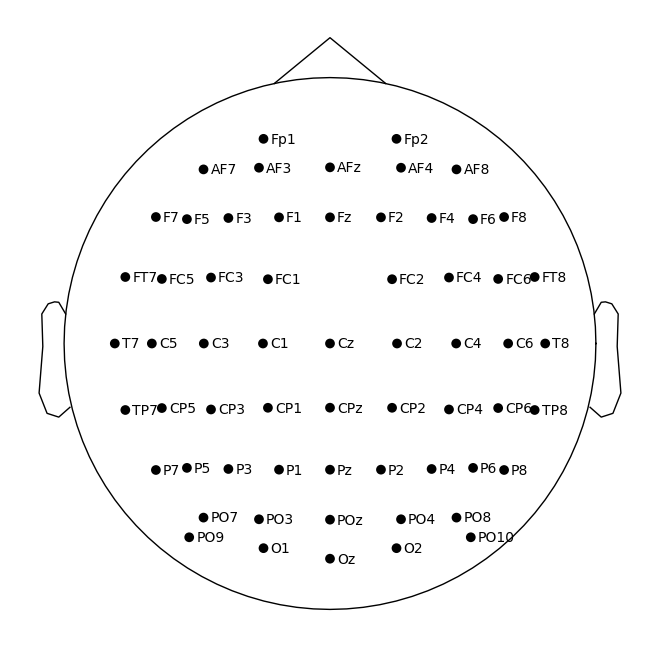

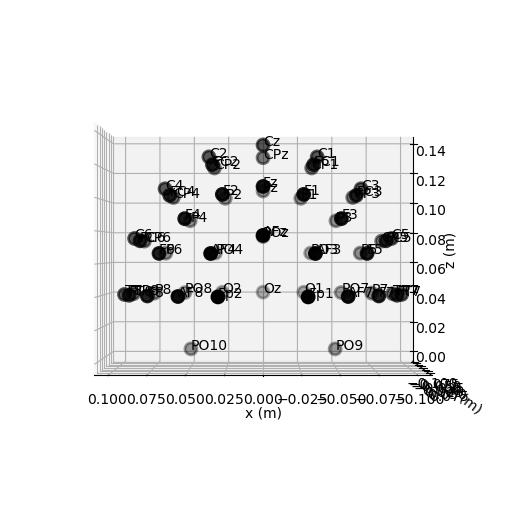

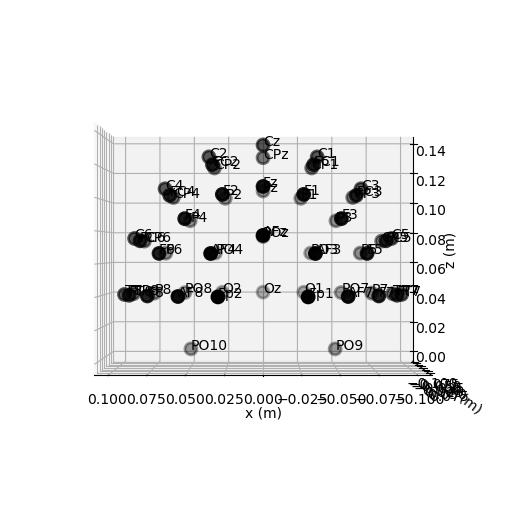

In [4]:
# Drop any non-EEG channels (e.g., VEOG for vertical eye movement)
if 'VEOG' in raw.ch_names:
    raw.drop_channels(['VEOG'])
    print("→ Channel 'VEOG' dropped.")
else:
    print("→ Channel 'VEOG' not found; no channels removed.")

# Verify channels list
print("Current channels:", raw.ch_names)

# Create a standard montage (BrainProducts RNP-BA-128)
montage = mne.channels.make_standard_montage('brainproducts-RNP-BA-128')

# Apply the montage to our raw data
# match_case=False allows for case-insensitive matching of channel names
# on_missing='warn' alerts us if channels don't match the montage
raw.set_montage(montage, match_case=False, on_missing='warn')

# Plot sensor locations to verify
# 2D topographic view of sensor locations
raw.plot_sensors(
    kind='topomap',
    show_names=True,
    title='2D EEG Sensor Montage'
)

# 3D view of sensor locations on a spherical head model
raw.plot_sensors(
    kind='3d',
    show_names=True,
    title='3D EEG Sensor Montage'
)

## Initial Data Inspection
Before processing, let's visualize the raw data to understand what we're working with:

### Plot the raw data

In [2]:
# This shows the time-domain signal for each EEG channel
raw.plot(scalings='auto')

Using qt as 2D backend.


Channels marked as bad:
none


### Calculate and plot the power spectral density (PSD)

Effective window size : 0.819 (s)


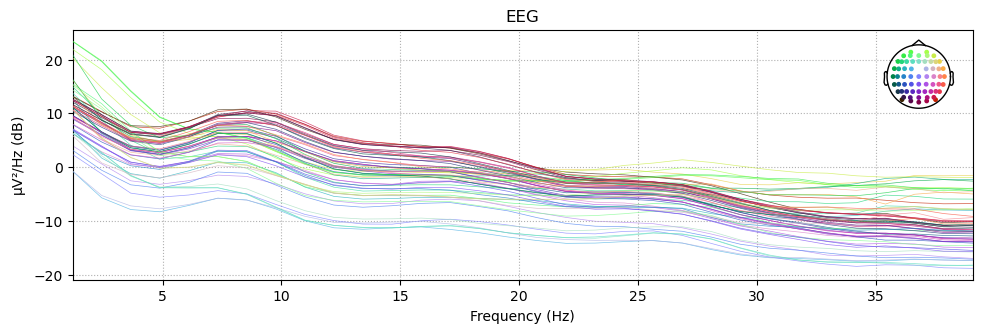

In [27]:
# This shows the frequency content of the EEG signal
raw.compute_psd(fmin=1, fmax=40).plot(show=False)

## Basic Preprocessing
Now let's perform some initial preprocessing steps:

In [5]:
# Create a copy of the raw data for processing
raw_processed = raw.copy()

# Step 1: Downsample the data to reduce computational load
# High sampling rates aren't always necessary for EEG analysis
print('Original Sampling Rate:', raw_processed.info['sfreq'])
if raw_processed.info['sfreq'] > 1000:
    raw_processed = raw_processed.resample(1000)  # Downsample to 1000 Hz
    print('New Sampling Rate:', raw_processed.info['sfreq'])

# Step 2: Remove power line noise using DSS (Denoising Source Separation)
# This is more effective than a notch filter for line noise removal
from meegkit import dss

# Define the line noise frequency (50 Hz in Europe, 60 Hz in US/Canada)
line_noise_frequency = 50  

# Get the EEG data as a numpy array (channels x time)
eeg_data = raw_processed.get_data()

# Apply DSS algorithm to remove line noise
# dss_line finds components that represent line noise and removes them
processed_data, components = dss.dss_line(
    eeg_data.T,                           # Data must be (time x channels)
    fline=line_noise_frequency,           # Line frequency to target
    sfreq=raw_processed.info['sfreq'],    # Sampling frequency
    show=False                            # Don't show the components
)

# Update the data in our raw object
raw_processed._data = processed_data.T    # Convert back to (channels x time)

# Step 3: Apply bandpass filter to focus on frequencies of interest
# This removes slow drifts and high-frequency noise
raw_processed.filter(
    l_freq=1,     # High-pass filter cutoff at 1 Hz
    h_freq=100,   # Low-pass filter cutoff at 100 Hz
    method='fir'  # Finite Impulse Response filter
)

Original Sampling Rate: 2500.0
New Sampling Rate: 1000.0
Power of components removed by DSS: 0.00
Effective window size : 2.048 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 s)



C:\Users\Amin\anaconda3\envs\comet\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


<RawBrainVision | sub-010004.eeg, 61 x 1022040 (1022.0 s), ~475.7 MB, data loaded>

## Automatic Bad Channel Detection
Bad channels can severely distort analyses and should be identified:

In [6]:
# Use PyPrep to automatically detect noisy/bad channels
from pyprep.find_noisy_channels import NoisyChannels

# Create a NoisyChannels object and find all types of bad channels
nd = NoisyChannels(raw_processed, random_state=1337)
nd.find_all_bads()

# Get the list of bad channels detected
if nd:
    bad_channels = nd.get_bads()
    print(f"Detected bad channels: {bad_channels}")
    
    # Mark these channels as bad in our data
    raw_processed.info['bads'] = bad_channels
    
    # Exclude the detected noisy channels from further processing
    # This doesn't drop them, just ignores them temporarily
    raw_processed.pick(picks='eeg', exclude='bads')
else:
    print("No bad channels detected")

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/204 [00:00<?,       ?it/s]


RANSAC done!
Detected bad channels: []


## Artifact Removal with ICA
Independent Component Analysis (ICA) is a powerful method for identifying and removing artifacts:

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 60 components
Fitting ICA took 964.7s.


C:\Users\Amin\AppData\Local\Temp\ipykernel_53144\1398450222.py:18: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw_processed, ica, method='iclabel')


Component classifications: ['eye blink', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'brain', 'muscle artifact', 'brain', 'brain', 'heart beat', 'brain', 'muscle artifact', 'brain', 'other', 'muscle artifact', 'brain', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'brain', 'brain', 'brain', 'brain', 'muscle artifact', 'brain', 'brain', 'brain', 'muscle artifact', 'muscle artifact', 'brain', 'brain', 'other', 'muscle artifact', 'brain', 'muscle artifact', 'other', 'brain', 'other', 'other', 'brain', 'other', 'brain', 'other', 'muscle artifact', 'other', 'other', 'other', 'brain', 'other', 'other', 'other', 'other', 'other', 'other', 'brain', 'other', 'brain', 'other', 'other']
Excluding these ICA components: [0, 1, 7, 10, 12, 15, 17, 18, 19, 24, 28, 29, 33, 35, 44]


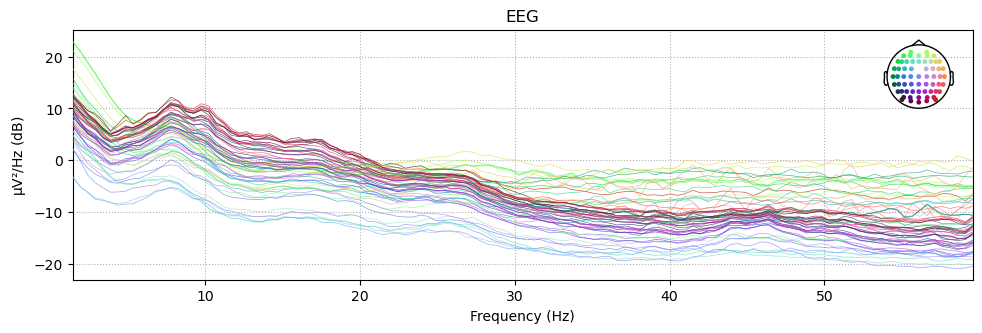

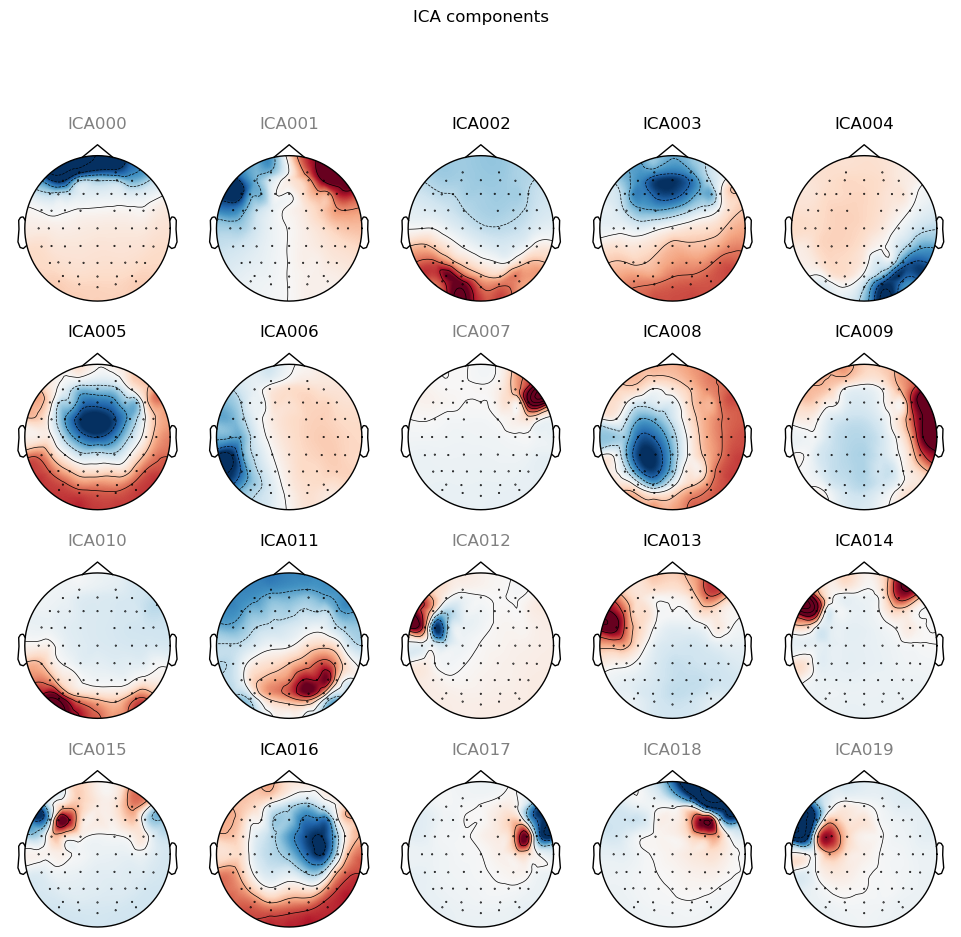

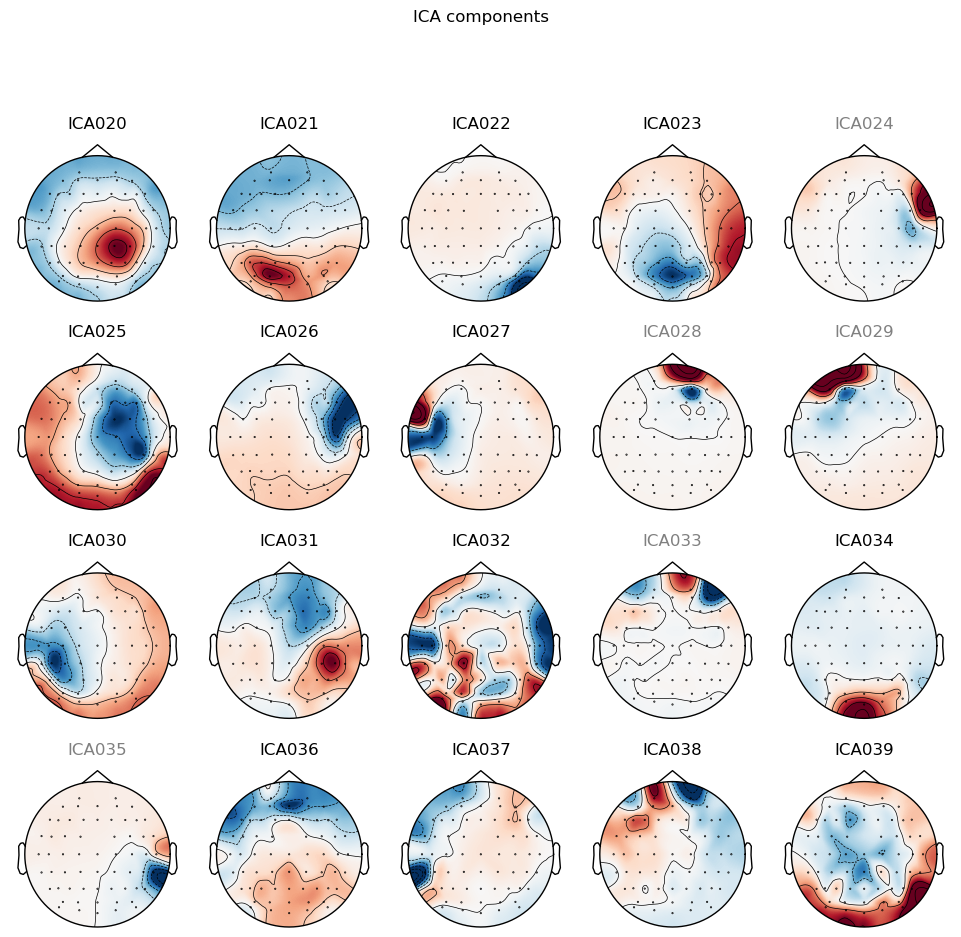

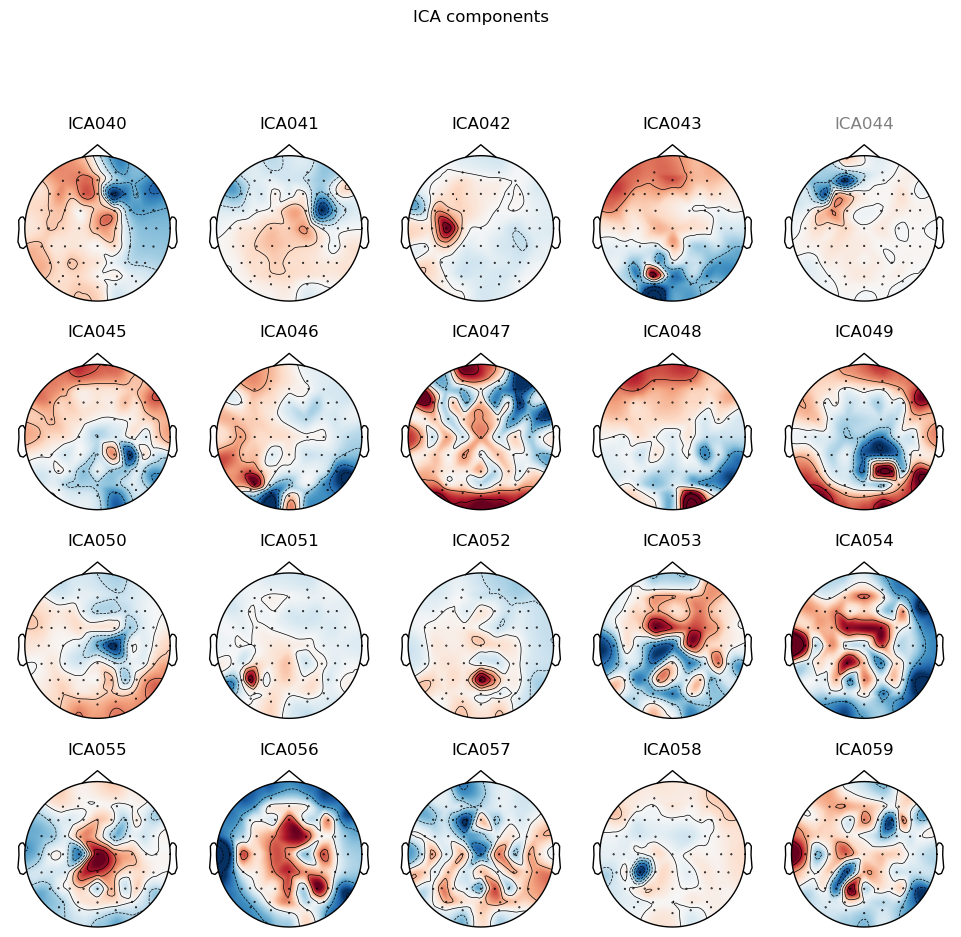

Applying ICA to Raw instance
    Transforming to ICA space (60 components)
    Zeroing out 15 ICA components
    Projecting back using 61 PCA components


In [7]:
# Apply ICA to decompose signals into independent components
from mne.preprocessing import ICA
from mne_icalabel import label_components

# First, re-reference to average to improve ICA decomposition
raw_processed.set_eeg_reference('average')

# Create an ICA object (we'll use FastICA which is faster than Infomax)
# n_components=None uses all components
ica = ICA(n_components=None, random_state=97, method="fastica")

# Fit the ICA model to our preprocessed data
ica.fit(raw_processed)

# Use ICLabel to automatically classify components
# ICLabel uses a deep neural network to classify components as:
# 'brain', 'muscle artifact', 'eye blink', 'heart beat', 'line noise', 'channel noise', or 'other'
ic_labels = label_components(raw_processed, ica, method='iclabel')

# Extract the labels for each component
labels = ic_labels["labels"]
print(f"Component classifications: {labels}")

# Determine which components to exclude (non-brain components)
# We want to keep components labeled as 'brain' or 'other' (uncertain)
exclude_idx = [
    idx for idx, label in enumerate(labels) 
    if label not in ["brain", "other"]
]

print(f"Excluding these ICA components: {exclude_idx}")

# Set the components to exclude
ica.exclude = exclude_idx

# Visualize the ICA components
# This shows the spatial pattern and time course of each component
ica.plot_components()

# Apply ICA to remove the artifactual components
# This reconstructs the signal without the excluded components
raw_processed = ica.apply(raw_processed)

## Channel Interpolation
After removing bad channels and artifacts, we can interpolate the missing channels:

In [8]:
# Interpolate the bad channels to restore the full channel set
# This estimates the signal at bad channel locations using nearby good channels
raw_processed.interpolate_bads(reset_bads=False)

C:\Users\Amin\AppData\Local\Temp\ipykernel_53144\3123608481.py:3: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_processed.interpolate_bads(reset_bads=False)


<RawBrainVision | sub-010004.eeg, 61 x 1022040 (1022.0 s), ~475.7 MB, data loaded>

## Saving the Processed Data
Finally, let's save our cleaned data for future analysis:

In [70]:
# Save the cleaned data in MNE
output_path = Path(f"{subject_id}_cleaned_resting_eeg.vhdr")
# Export Raw to external formats
mne.export.export_raw(output_path, raw_processed, fmt='auto', overwrite=True)
print(f"Cleaned data saved to {output_path}")

C:\Users\Amin\anaconda3\envs\comet\Lib\site-packages\pybv\_export.py:61: RuntimeWarning: Encountered data in 'short' format. Converting to float32.
  warn(


Cleaned data saved to sub-010004_cleaned_resting_eeg.vhdr
